# Prerequisites

- Group theory
- ECDLP
- Elliptic curves over finite fields
- Singular curves (general intuition)

In [2]:

from collections import namedtuple
from Crypto.Util.number import inverse, bytes_to_long, long_to_bytes, getPrime

# Create a simple Point class to represent the affine points.
Point = namedtuple("Point", "x y")
Curve_custom = namedtuple("Curve", "a, b, c, p")
# The point at infinity (origin for the group law).
O = 'Origin'


def check_point(P, C):
    if P == O:
        return True
    else:
        return (P.y**2 - (P.x**3 + C.a * P.x **2 + C.b*P.x + C.c)) % C.p == 0 and 0 <= int(P.x) < C.p and 0 <= int(P.y) < C.p


def point_inverse(P, C):
    if P == O:
        return P
    return Point(P.x, -P.y % C.p)


def point_addition(P, Q, C):
    if P == O:
        return Q
    elif Q == O:
        return P
    elif Q == point_inverse(P, C):
        return O
    else:
        if P == Q:
            lam = (3*P.x**2 + C.a*2*P.x + C.b) * inverse(int((2*P.y)), C.p)
            lam %= C.p
        else:
            lam = (Q.y - P.y) * inverse(int((Q.x - P.x)), C.p)
            lam %= C.p
    Rx = (lam**2 - C.a - P.x - Q.x) % C.p
    nu = (P.y - lam * P.x) % C.p
    Ry = -(lam*Rx + nu) % C.p
    R = Point(Rx, Ry)
    #assert check_point(R)
    return R


def double_and_add(n, P, C):
    Q = P
    R = O
    while n > 0:
        if n % 2 == 1:
            R = point_addition(R, Q, C)
        Q = point_addition(Q, Q, C)
        n = n // 2
    #assert check_point(R)
    return R


# Theory

**Task**
- Find a way to break ECDLP on singular curves over finite fields

*Intuition*:
- Map the curves to a finite field and break it there

We consider our curve:
- $C : y^2 = x^3 + ax^2 + bx + c$
- with the discriminant $D=-4a^3c+a^2b^2+18abc-4b^3-27c^2$

**Singular curve**: 
- Let $C$ be  a  cubic  curve  with  a  singular  point $S\in C$.  Then  any  line through $S$ intersects $C$ at $S$ with multiplicity at least two. If there were a second singular point $S^\prime \in C$, then the line connecting $S$ and $S^\prime$ would intersect $C$ at least twice at $S$ and at least twice at $S′$ ,so $L$ would intersect $C$ at least four times. But a line and a cubic intersect only three times counting multiplicities. Thus a cubic curve can have **at most one singular point**.

If $D = 0$ then our curve is singular

## Singular curves over finite fields

When we are working in a finite field mod $p$ (or an extension of it) the curve is singular if $p$ divides $D$ 
- We reduce $a, b, c$ mod $p$, then $D$ which is a combination of these will also get reduced mod $p$ 
- if $D \equiv 0 \ mod \ p \Rightarrow$ the curve is singular

There are 3 possible pictures for the singularity $S$ depending on whether $f$ has a double root or triple root, and if a double root, whether the tangent directions are real or complex

We will consider $C$ to be a singular curve and $C_{ns}$ to be the set of nonsingular points on $C$. If $C$ is defined over some finite field $K$ (Although the graphs are over real numbers for visualisation purposes) we will let $C_{ns}(K)$ to be the set of nonsingular points of $C(K)$

## Cusps

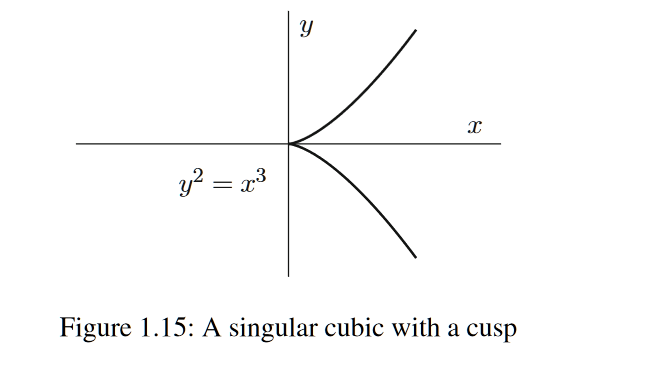

Cusps are given by the equation $y^2 = x^3$ => we have a triple root at $x = 0 \Rightarrow S = (0,0) = $ singular point. Since we define the sum of points based on tangents and the a line through $(0,0)$ has **at most** one intersection with the curve => no line that passes through 2 points will pass through $(0,0)$

Consider the map
- $C_{ns}(K) \to (K)$
- $(x,y) \mapsto \dfrac x y$
- $\mathcal{O} \mapsto 0$

This map is an isomorphism between $C_{ns}(K)$ and $K$ where $K$  is regarded as an aditive group $K^+$

**Proof**

Let $t = \dfrac x y \ \overset{y^2=x^3}{\Rightarrow}$

$$x = \left( \dfrac y x \right) ^2 = \dfrac 1 {t^2}$$

$$y = \dfrac x t = \dfrac 1 {t^3}$$

$$t = 0 \text{ for } (x,y) = \mathcal{O}$$

We want to express all the points in $C_{ns}(K)$ in terms of $t$

*Addition*:
$$x_3 = \underbrace{\left(\cfrac {y_2 - y_1} {x_2 - x_1} \right)^2}_{\lambda^2} - x_1 - x_2 \overset{x = \frac 1 {t^2}, \ \ y = \frac 1 {t^3}}{ \Rightarrow} t^{-2}_3= \left( \cfrac {t^{-3}_2-t^{-3}_1} {t^{-2}_2-t^{-2}_1} \right)^2-t^{-2}_1-t^{-2}_2 = t^{-2}_3=(t_1+t_2)^{-2}$$
$$−y_3=\left(\cfrac{y_2−y_1}{x_2−x_1}\right)(x_3−x_1)+y_1 \Rightarrow t^{−3}_3=(t_1+t_2)^{−3}$$
- Take the ratio => $t_3 = t_1 + t_2$

*Doubling*:
- Proof is similar, just substitute

**Note**
- You can transfer any equation with triple root to this form by shifting it by the root

### Code for cusps

In [3]:
p = getPrime(256)
p

66251876883406452059243663038106533608890178389562613837369119459469695974903

In [4]:
#Consider the equation with the trpile root r 
r = 123
PF.<X> = PolynomialRing(GF(p))
f =  (X - r) ^ 3
print(f.roots())
print(f)

[(123, 3)]
X^3 + 66251876883406452059243663038106533608890178389562613837369119459469695974534*X^2 + 45387*X + 66251876883406452059243663038106533608890178389562613837369119459469694114036


In [5]:
c, b, a = int(f[0]), int(f[1]), int(f[2])

In [6]:
C = Curve_custom(a, b, c, p)

In [7]:
check_point(Point(r+1,1), C)

True

In [8]:
#Take a random point G and some message m => P
G = double_and_add(7, Point(r+1,1), C)
m = bytes_to_long(b'secretmessage')
P = double_and_add(m, G, C)
check_point(G, C), check_point(P, C)

(True, True)

In [9]:
#define our isomorphism
def isomap(A, p):
    if (A.x, A.y) == (0,0):
        return 0
    else:
        return (A.x * inverse(A.y, p)) % p

In [10]:
# Shift our curve with the r
f_shifted = f.subs(X = X + r)
f_shifted

X^3

In [11]:
C_shifted = Curve_custom(f_shifted[2], f_shifted[1], f_shifted[0], p) # a b c are 0
C_shifted

Curve(a=0, b=0, c=0, p=66251876883406452059243663038106533608890178389562613837369119459469695974903)

In [12]:
G_shifted = Point((G.x - r) % p , G.y)
P_shifted = Point((P.x - r) % p, P.y)
check_point(G_shifted, C_shifted), check_point(P_shifted, C_shifted)

(True, True)

In [13]:
P_map = isomap(P_shifted, p)
G_map = isomap(G_shifted, p)

In [14]:
m_decr = (P_map * inverse(G_map, p)) % p #additive inverse
print(long_to_bytes(m_decr))

b'secretmessage'


## Nodes

https://crypto.stackexchange.com/questions/61302/how-to-solve-this-ecdlp/61434#61434

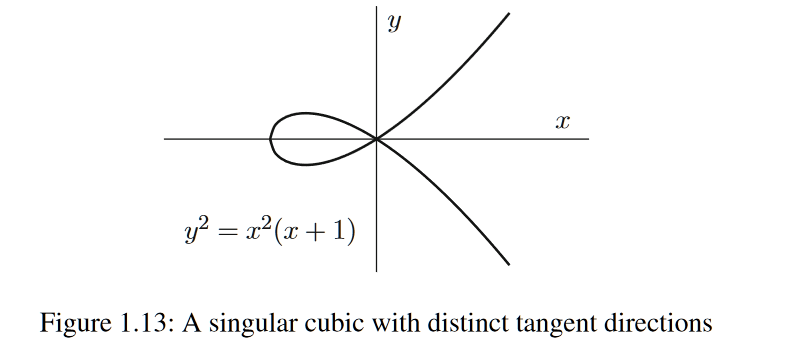

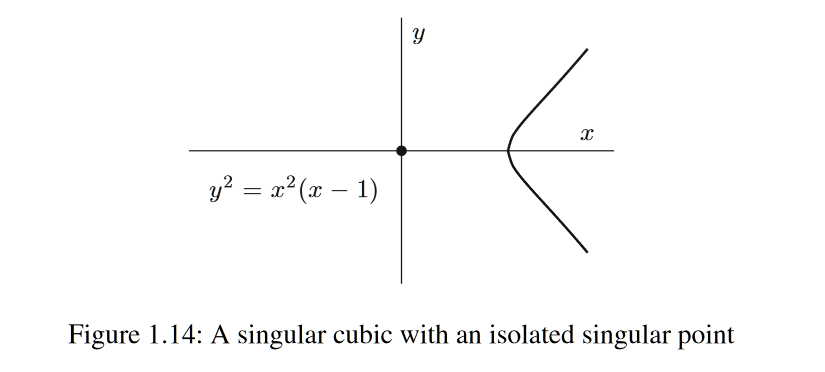

In this case our curve equation has a double root and one simple root. We will consider the curve $C: y^2 =x^2(x+a)$ over some field $K$ with the observation that any type of curve can be reduced to this form with a change of variables and some shifts. The point $(0,0)$ is the singularity

Rewrite the equation as $\left(\cfrac y x \right)^2 = a + x$. When $x$is near $0$, the right side of this equation is approximately $a$. => C is approximated by $\left(\cfrac y x \right)^2 = a => \cfrac y x = \pm \alpha$ where $\alpha = \sqrt a$ near $x =0$

The 2 "tangents" to E at (0,0) are $y = \alpha x$ and $y = -\alpha x$

Consider the map
- $C_{ns}(K) \longrightarrow (K)$
- $(x,y) \longmapsto \cfrac {y+\alpha x} {y - \alpha x}$
- $\mathcal{O} \longmapsto 1$

Then 
1. If $\alpha \in K$ ($\alpha$ is square) this map is an isomorphism between $C_{ns}(K)$ and $K$ where $K$  is regarded as a multiplicative group $K^+$
2. If $\alpha \not \in K$ then the map is an isomorphism between $C_{ns}(K) \sim \{u+αv|u, \ v∈K, \ u^2−av^2=1\}$ <- group under multiplication

### Code for nodes

In [15]:
p = getPrime(64)
p

13587888526382196463

In [16]:
#Consider the equation with the trpile root r 
r0 = 4
r1 = 123
PF.<X> = PolynomialRing(GF(p))
f =  (X - r0) ^ 2 * (X - r1)
print(f.roots())
print(f)

[(123, 1), (4, 2)]
X^3 + 13587888526382196332*X^2 + 1000*X + 13587888526382194495


In [17]:
c, b, a = int(f[0]), int(f[1]), int(f[2])
C = Curve_custom(a, b, c, p)
C

Curve(a=13587888526382196332, b=1000, c=13587888526382194495, p=13587888526382196463)

In [18]:
is_square(f(r0 + 2)) # find a square

True

In [19]:
#Take a random point G and some message m => P
G = double_and_add(7, Point(r0+2,sqrt(f(r0+2))), C)
m = bytes_to_long(b'secret')
P = double_and_add(m, G, C)
check_point(G, C), check_point(P, C)

(True, True)

In [20]:
long_to_bytes(m)

b'secret'

In [21]:
#define our isomorphism
def isomap2(A, p, alpha):
    if (A.x, A.y) == (0,0):
        return 0
    else:
        return ((A.y + alpha * A.x) * inverse(int(A.y - alpha * A.x), p)) % p

In [22]:
# Shift our curve with the r
f_shifted = f.subs(X = X + r0)
f_shifted

X^3 + 13587888526382196344*X^2

In [23]:
C_shifted = Curve_custom(f_shifted[2], f_shifted[1], f_shifted[0], p) # a b c are 0
C_shifted

Curve(a=13587888526382196344, b=0, c=0, p=13587888526382196463)

In [24]:
G_shifted = Point((G.x - r0) % p , G.y)
P_shifted = Point((P.x - r0) % p, P.y)
check_point(G_shifted, C_shifted), check_point(P_shifted, C_shifted)

(True, True)

In [25]:
print(is_square(C_shifted.a))
alpha = sqrt(C_shifted.a)


True


In [26]:
P_map = isomap2(P_shifted, p, alpha)
G_map = isomap2(G_shifted, p, alpha)

In [27]:
m_decr = discrete_log(P_map, G_map)#multiplicative inverse
print(long_to_bytes(m_decr))

b'secret'
Exiting Sage (CPU time 0m27.72s, Wall time 6m25.17s).


# Resources
- Silverman's 
    - Rational points on elliptic curves -> P107-110
    - The arithmetic of elliptic curves -> P55
- Elliptic Curves Number Theory and Cryptography (2nd) LAWRENCE C. WASHINGTON ->  P59